# Watson Visual Recognition Training with Spectrogram Images from SETI Signal Data

* https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/
* https://www.ibm.com/watson/developercloud/doc/visual-recognition/customizing.html
* https://github.com/watson-developer-cloud/python-sdk
* https://github.com/watson-developer-cloud/python-sdk/blob/master/watson_developer_cloud/visual_recognition_v3.py

<hr>

## Install the Watson Developer Cloud Python SDK

* Install the Python SDK if has not been previously installed **`!pip install --upgrade watson-developer-cloud`**
* Restart the kernel, after installing the SDK

In [1]:
#!pip install --user --upgrade watson-developer-cloud

In [86]:
#Making a local folder to put my data.

#NOTE: YOU MUST do something like this on a Spark Enterprise cluster at the hackathon so that
#you can put your data into a separate local file space. Otherwise, you'll likely collide with 
#your fellow participants. 

my_team_name_data_folder = 'my_team_name_data_folder'

mydatafolder = os.environ['PWD'] + '/' +  my_team_name_data_folder + '/zipfiles'
if os.path.exists(mydatafolder) is False:
    os.makedirs(mydatafolder)

In [3]:
!ls my_team_name_data_folder/zipfiles

classification_1_narrowbanddrd.zip  classification_3_noise.zip
classification_1_narrowband.zip     classification_3_squiggle.zip
classification_1_noise.zip	    classification_4_narrowbanddrd.zip
classification_1_squiggle.zip	    classification_4_narrowband.zip
classification_2_narrowbanddrd.zip  classification_4_noise.zip
classification_2_narrowband.zip     classification_4_squiggle.zip
classification_2_noise.zip	    testset_narrowbanddrd.zip
classification_2_squiggle.zip	    testset_narrowband.zip
classification_3_narrowbanddrd.zip  testset_noise.zip
classification_3_narrowband.zip     testset_squiggle.zip


In [4]:
from __future__ import division

import cStringIO
import glob
import json
import os
import requests
import time
import timeit
import zipfile
import copy

from random import randint

import matplotlib.pyplot as plt
import numpy as np

import ibmseti

from watson_developer_cloud import VisualRecognitionV3

In [5]:
apiVer = VisualRecognitionV3.latest_version #'2016-05-20'
classifier_prefix = 'setisignals'

#You can sign up with WatsonVR through Bluemix to get a key
#However, Hackathon participants will be provided with a WATSON VR key that has more free API calls per day.
apiKey = 'WATSON-VISUAL-RECOGNITION-API-KEY'  

<br/>
## Init the Watson Visual Recognition Python Library

* you may need to install the SDK first: **`!pip install --upgrade watson-developer-cloud`**
* you will need the **API** key from the Watson Visual Recognition Service

In [7]:
vr = VisualRecognitionV3(apiVer, api_key=apiKey)

<br/>
## Look For Existing Custom Classifier
Use an existing custom classifier (and update) if one exists, else a new custom classifier will be created

In [8]:
## View all of your classifiers

classifiers = vr.list_classifiers()
print json.dumps(classifiers, indent=2)

{
  "classifiers": []
}


In [9]:
## Run this cell ONLY IF you want to REMOVE all classifiers
# Otherwise, the subsequent cell will append images to the `classifier_prefix` classifier
classifiers = vr.list_classifiers()
for c in classifiers['classifiers']:
    vr.delete_classifier(c['classifier_id'])

In [10]:
classifiers = vr.list_classifiers()
print json.dumps(classifiers, indent=2)

{
  "classifiers": []
}


In [11]:
#Create new classifier, or get the ID for the latest SETISIGNALS classifier

classifier_id = None
classifier = None

classifiers = vr.list_classifiers()

for c in classifiers['classifiers']:
    if c['status'] == 'ready' and (classifier_prefix in c['classifier_id']):
        classifier_id = c['classifier_id']


if classifier_id is not None:
    classifier = vr.get_classifier(classifier_id)
    print '\r\nFound classifer:\r\n\r\n{}'.format(json.dumps(classifier, indent=2))
else:
    print 'No custom classifier available\r\n'
    print(json.dumps(classifiers, indent=2))

No custom classifier available

{
  "classifiers": []
}


<br/>
## Send the Images Archives to the Watson Visual Recognition Service for Training

* https://www.ibm.com/watson/developercloud/doc/visual-recognition/customizing.html
* https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/
* https://github.com/watson-developer-cloud/python-sdk

In [ ]:
squiggle = sorted(glob.glob('{}/classification_*_squiggle.zip'.format(mydatafolder)))
narrowband = sorted(glob.glob('{}/classification_*_narrowband.zip'.format(mydatafolder)))
narrowbanddrd = sorted(glob.glob('{}/classification_*_narrowbanddrd.zip'.format(mydatafolder)))
noise = sorted(glob.glob('{}/classification_*_noise.zip'.format(mydatafolder)))

sq = len(squiggle)
nb = len(narrowband)
nd = len(narrowbanddrd)
ns = len(noise)

## Possible todo here: Try using the 'noise' as a "negative" example when training Watson. See the Watson documentation.

num = max(sq, nb, nd, ns)
#num = max(sq, nb, nd)

if classifier_id is None:
    print 'Adding custom classifier ... this may take awhile'
else:
    print 'Updating custom classifier {} ... this may take awhile'.format(classifier_id)

for i in range(num):
    squiggle_p = open(squiggle[i], 'rb') if i < sq else None
    narrowband_p = open(narrowband[i], 'rb') if i < nb else None
    narrowbanddrd_p = open(narrowbanddrd[i], 'rb') if i < nd else None
    noise_p = open(noise[i], 'rb') if i < ns else None

    if classifier_id is None:
#        print 'Creating with\r\n{}\r\n{}\r\n{}\r'.format(squiggle_p, narrowband_p, narrowbanddrd_p)  #use this line if going to use 'noise' as negative example
        print 'Creating with\r\n{}\r\n{}\r\n{}\r\n{}\r'.format(squiggle_p, narrowband_p, narrowbanddrd_p, noise_p)
        classifier = vr.create_classifier(
            classifier_prefix,
            squiggle_positive_examples = squiggle_p,
            narrowband_positive_examples = narrowband_p,
            narrowbanddrd_positive_examples = narrowbanddrd_p,
            noise_positive_examples = noise_p  #remove this if going to use noise as 'negative' examples
        )
        
        classifier_id = classifier['classifier_id']
    else:
        print 'Updating with\r\n{}\r\n{}\r\n{}\r\n{}\r'.format(squiggle_p, narrowband_p, narrowbanddrd_p, noise_p)
#        print 'Updating with\r\n{}\r\n{}\r\n{}\r'.format(squiggle_p, narrowband_p, narrowbanddrd_p)  #use this line if going to use 'noise' as negative example
        classifier = vr.update_classifier(
            classifier_id,
            squiggle_positive_examples = squiggle_p,
            narrowband_positive_examples = narrowband_p,
            narrowbanddrd_positive_examples = narrowbanddrd_p,
            noise_positive_examples = noise_p #remove this if going to use noise as 'negative' examples
        )

    if squiggle_p is not None:
        squiggle_p.close()
    if narrowband_p is not None:
        narrowband_p.close()
    if narrowbanddrd_p is not None:
        narrowbanddrd_p.close()
    if noise_p is not None:
        noise_p.close()

    if classifier is not None:
        print('Classifier: {}'.format(classifier_id))
        status = classifier['status']
        startTimer = timeit.default_timer()
        while status in ['training', 'retraining']:
            print('Status: {}'.format(status))
            time.sleep(10)
            classifier = vr.get_classifier(classifier_id)
            status = classifier['status']
        stopTimer = timeit.default_timer()
        print '{} took {} minutes'.format('Training' if i == 0 else 'Retraining', int(stopTimer - startTimer) / 60)

print(json.dumps(vr.get_classifier(classifier_id), indent=2))


<br/>
## Take a Random Data File for Testing

* Take a random data file from the test set
* Create a Spectrogram Image

In [62]:
zz = zipfile.ZipFile(mydatafolder + '/' + 'testset_narrowband.zip')

In [63]:
test_list = zz.namelist()
randomSignal = zz.open(test_list[10],'r')

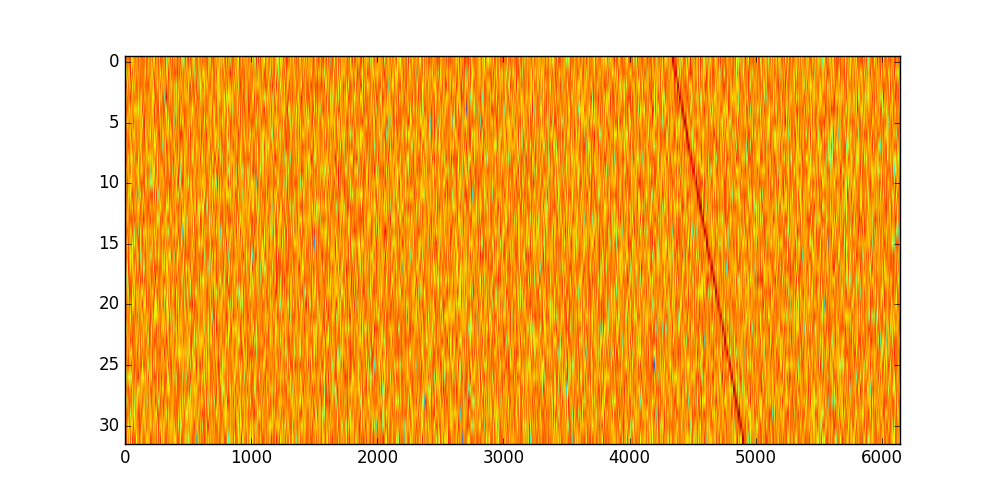

In [64]:
from IPython.display import Image
squigImg = randomSignal.read()
Image(squigImg)

In [65]:
#note - have to 'open' this again because it was already .read() out in the line above
randomSignal = zz.open(test_list[10],'r')

url_result = vr.classify(images_file=randomSignal, classifier_ids=classifier_id, threshold=0.0)

print(json.dumps(url_result, indent=2))

{
  "images": [
    {
      "image": "gpfs/fs01/user/sfa7-9e7464df3e1117-5edfd8a0d95d/notebook/work/my_team_name_data_folder/png/86a3cde6-be85-4130-a2a7-d374c2fd16ff.dat.png", 
      "classifiers": [
        {
          "classes": [
            {
              "score": 0.627177, 
              "class": "narrowband"
            }, 
            {
              "score": 0.473352, 
              "class": "narrowbanddrd"
            }, 
            {
              "score": 0.144517, 
              "class": "noise"
            }, 
            {
              "score": 0.0575557, 
              "class": "squiggle"
            }
          ], 
          "classifier_id": "setisignals_207850522", 
          "name": "setisignals"
        }
      ]
    }
  ], 
  "custom_classes": 4, 
  "images_processed": 1
}


<br/>
## Run the Complete Test Set



In [55]:
#Create a dictionary object to store results from Watson

from collections import defaultdict

class_list = ['squiggle', 'noise', 'narrowband', 'narrowbanddrd']

results_group_by_class = {}
for classification in class_list:
    results_group_by_class[classification] = defaultdict(list)
    
failed_to_classify_uuid_list = []

print classifier_id

results_group_by_class


setisignals_207850522


{'narrowband': defaultdict(list, {}),
 'narrowbanddrd': defaultdict(list, {}),
 'noise': defaultdict(list, {}),
 'squiggle': defaultdict(list, {})}

In [ ]:
### NOTE. If this breaks due to a requests timeout or other error: **just restart this cell**
#   The processing should pick up where it left off. 

##  NOTE: This code could be more efficient and make fewer HTTP calls to Watson. I could have dumped the testset_<class>.zip into 
#     smaller zip files (testset_<class>_N.zip for N = 1,2,3,4...) and then made a single call to Watson with each smaller zip file
#
#    Example:
#     with open(mydatafolder + '/' + 'testset_squiggle_1.zip', 'rb') as squigglezips:
#       url_result = vr.classify(images_file=squigglezips, classifier_ids=classifier_id, threshold=0.0)

#     The 'testset_squiggle.zip' files are too large to make a single to call to Watson, and so this code goes through
#     each file one by one.

### ASLO, I could have farmed this out to the Spark executor nodes as well. 

for sigclass in class_list:
    
    passed = 0
    
    zz = zipfile.ZipFile(mydatafolder + '/' + 'testset_{}.zip'.format(sigclass))
    zzlist = zz.namelist()
    
    ### REDUCING TESTING to only the first 30 signals in the test set -- to keep this demonstration code faster.
    
    zzlist = zzlist[:30]  
    
    zzlistsize = len(zzlist)
    
    startTimer = timeit.default_timer()

    resdict = results_group_by_class[classification]
    
    print 'Running test ({} images) for {}... this may take a while.'.format(zzlistsize, sigclass)

    for fn in zzlist:
        pngfilename = fn.split('/')[-1]
        uuid = pngfilename.split('.')[0]
        classification = sigclass
        
        if uuid in resdict['uuid'] or uuid in failed_to_classify_uuid_list:
            print "   have already classified {}".format(uuid)
            continue
        
        classify_result = vr.classify(images_file=zz.open(fn,'r'), classifier_ids=classifier_id, threshold=0.0)
        
        maxscore = 0
        maxscoreclass = None

        classifiers_arr = classify_result['images'][0]['classifiers']
        
        score_list = []
        for classifier_result in classifiers_arr:
            for class_result in classifier_result['classes']:
                score_list.append((class_result['class'],class_result['score']))
                if class_result['score'] > maxscore:
                    maxscore = class_result['score']
                    maxscoreclass = class_result['class']

        #sort alphabetically
        score_list.sort(key = lambda x: x[0])
        score_list = map(lambda x:x[1], score_list)

        if maxscoreclass is None:
            print 'Failed: {} - Actual: {}, No classification returned'.format(pngfilename, classification)
            #print(json.dumps(classify_result, indent=2))

        elif maxscoreclass != classification:
            print 'Failed: {} - Actual: {}, Watson Predicted: {} ({})'.format(pngfilename, classification, maxscoreclass, maxscore)
        else:
            passed += 1
            print 'Passed: {} - Actual: {}, Watson Predicted: {} ({})'.format(pngfilename, classification, maxscoreclass, maxscore)

        if maxscoreclass is not None:
            resdict['signal_classification'].append(classification)
            resdict['uuid'].append(uuid)
            resdict['watson_class'].append(maxscoreclass)
            resdict['watson_class_score'].append(maxscore)
            resdict['scores'].append(score_list)
        else:
            #add to failed list
            failed_to_classify_uuid_list.append(uuid)

    stopTimer = timeit.default_timer()

    print 'Test Score: {}% ({} of {} Passed)'.format(int((float(passed) / zzlistsize) * 100), passed, zzlistsize)
    print 'Tested {} images in {} minutes'.format(zzlistsize, int(stopTimer - startTimer) / 60)

print "DONE"
        

In [59]:
import pickle
pickle.dump(results_group_by_class, open(mydatafolder + '/' + "watson_results.pickle", "w"))

In [76]:
watson_results = pickle.load(open("watson_results.pickle","r"))
# reorganize the watson_results dictionary to extract
# a list of [true_class, [scores], estimated_class] and
# use these for measuring our model's performance

class_scores = []
for k in watson_results.keys():
    class_scores += zip(watson_results[k]['uuid'], watson_results[k]['signal_classification'], watson_results[k]['scores'], watson_results[k]['watson_class'] )

In [77]:
class_scores[100]

('a5beea56-8ca4-469c-b4a4-e2f5094f0673',
 'narrowband',
 [0.520088, 0.608742, 0.046702, 0.0462171],
 u'narrowbanddrd')

In [78]:
from sklearn.metrics import classification_report
import sklearn

y_train = [x[1] for x in class_scores]
y_pred = [x[3] for x in class_scores]
y_prob = [x[2] for x in class_scores]
#we normalize the Watson score values to 1 in order to use them in the log_loss calculation even though the Watson VR scores are not true class prediction probabilities
y_prob = map(lambda x: (x, sum(x)), y_prob)
y_prob = map(lambda x: [y / x[1] for y in x[0]], y_prob)

print sklearn.metrics.classification_report(y_train,y_pred)
print sklearn.metrics.confusion_matrix(y_train,y_pred)
print("Classification accuracy: %0.6f" % sklearn.metrics.accuracy_score(y_train,y_pred) )
print("Log Loss: %0.6f" % sklearn.metrics.log_loss(y_train,y_prob) )

               precision    recall  f1-score   support

   narrowband       0.57      0.64      0.60        50
narrowbanddrd       0.59      0.52      0.55        50
        noise       1.00      1.00      1.00        50
     squiggle       1.00      1.00      1.00        50

  avg / total       0.79      0.79      0.79       200

[[32 18  0  0]
 [24 26  0  0]
 [ 0  0 50  0]
 [ 0  0  0 50]]
Classification accuracy: 0.790000
Log Loss: 0.525832


# Generate CSV file for Scoreboard

Here's an example of what the CSV file should look like for submission to the scoreboard. Although, in this case, we only have 4 classes instead of 7.

In [87]:
import csv
my_output_results = my_team_name_data_folder + '/' + 'watson_scores.csv'
with open(my_output_results, 'w') as csvfile:
    fwriter = csv.writer(csvfile, delimiter=',')
    for row in class_scores:
        fwriter.writerow([row[0]] + row[2])

In [ ]:
!cat my_team_name_data_folder/watson_scores.csv